In [50]:
import json

ATTACK = 'other_attacks'
BENIGN = 'benign'

with open("../../data/pre_process/dissection_clean/both.json") as f:
    my_json = json.load(f)

total_dict = {
    BENIGN : [],
    ATTACK : [],
}

attack_list = set()

for dissected_pkt in my_json:

    is_attack = int(dissected_pkt["common"].pop("is_attack"))
    attack_type = dissected_pkt["common"]["type"]
    attack_list.add(attack_type)

    packet_dict = dissected_pkt["common"].copy()
    for protocols in dissected_pkt["protocols"].values():
        for layer in protocols:
            packet_dict.update(layer)

    label = BENIGN if not is_attack else ATTACK

    total_dict[label].append(packet_dict)

In [ ]:
attack_list

{'add_random_nf',
 'applicative_scan',
 'cn_mitm',
 'deregister_random_ue',
 'downlink_wake_random',
 'flood_deletion',
 'flood_etablishment',
 'fuzz',
 'modify_drop',
 'modify_dupl',
 'pfcp_in_gtp',
 'register_random_ue',
 'remove_random_nf',
 'restart',
 'seid_fuzzing',
 'set_random_ue_idle',
 'uplink_spoofing',
 'uplink_wake_random_u',
 'user_traffic'}

In [ ]:
from datetime import datetime

ts_dict = {
    BENIGN : [],
    ATTACK : [],
    'applicative_scan' : [],
    'cn_mitm' : [],
    'flood_deletion' : [],
    'flood_etablishment' : [],
    'fuzz' : [],
    'seid_fuzzing' : []
}

for label in [BENIGN, ATTACK]:
    for packet in total_dict[label]:
        attack_type = packet.pop("type")

        ts = packet["ts"]
        ts = datetime.fromtimestamp(ts)

        if attack_type in ts_dict.keys():
            ts_dict[attack_type].append(ts)

        else :
            ts_dict[label].append(ts)

In [53]:
ts_dict["scan"] = ts_dict.pop("applicative_scan")

C:\Users\thoger\AppData\Local\Temp\ipykernel_14240\3180081253.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(counts.columns))


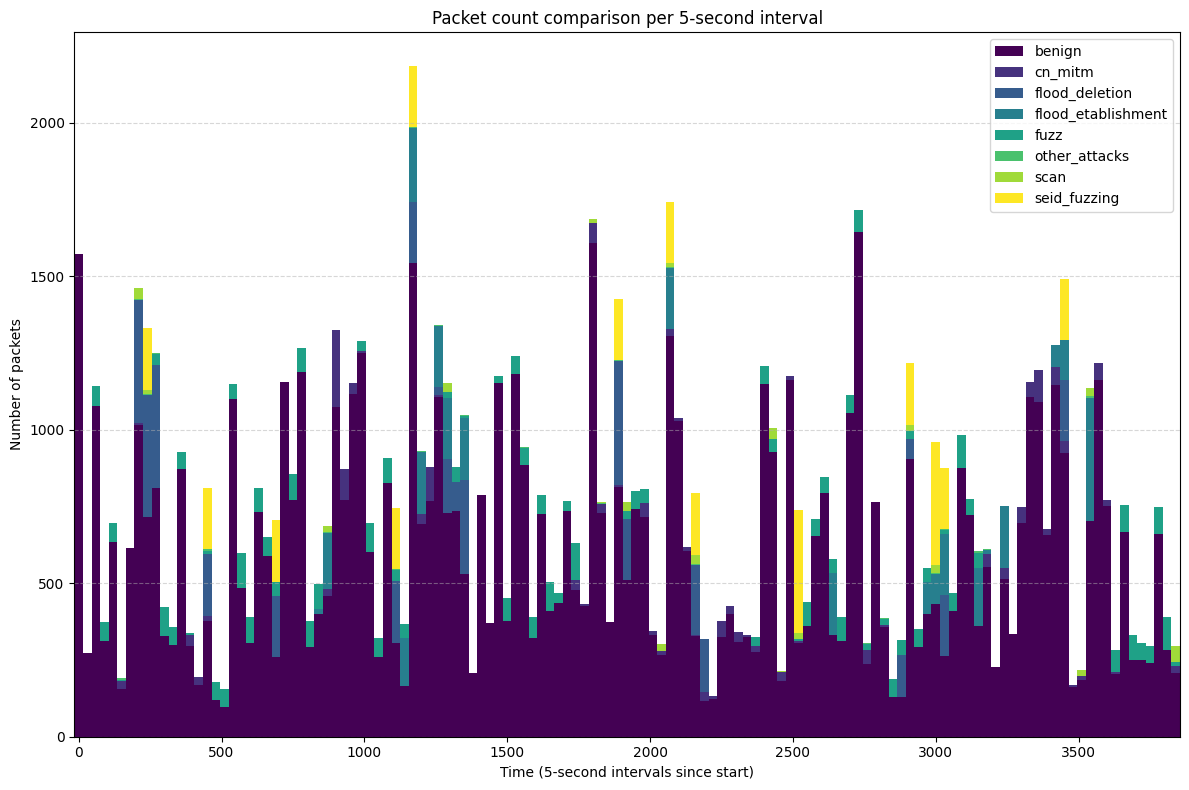

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Construire un DataFrame global
dfs = []
for key, timestamps in ts_dict.items():
    if len(timestamps) == 0:
        continue
    df_temp = pd.DataFrame({'time': pd.to_datetime(timestamps), 'source': key})
    dfs.append(df_temp)

if not dfs:
    print("Aucune donnée à afficher.")
else:
    df = pd.concat(dfs)

    # 2️⃣ Grouper par tranches de 5 secondes
    df['bin'] = ((df['time'] - df['time'].min()).dt.total_seconds() // 30 * 30).astype(int)

    # 3️⃣ Compter les occurrences par 'bin' et 'source'
    counts = df.groupby(['bin', 'source']).size().unstack(fill_value=0)

    # 4️⃣ Tracer en barres empilées
    plt.figure(figsize=(12, 8))

    colors = plt.cm.get_cmap('viridis', len(counts.columns))

    bottom = np.zeros(len(counts))
    for i, col in enumerate(counts.columns):
        plt.bar(counts.index, counts[col], width=30, bottom=bottom, label=col, color=colors(i))
        bottom += counts[col].values

    # 5️⃣ Mise en forme du graphique
    plt.xlabel("Time (5-second intervals since start)")
    plt.ylabel("Number of packets")
    plt.title("Packet count comparison per 5-second interval")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # 🔧 Ajustements demandés :
    plt.margins(x=0)   # Supprime les marges verticales inutiles
    plt.tight_layout()
    plt.show()
